# fwd / inv of a polarized block with a coincident loop system

In this notebook, I set up a simple example where we use the dipole model to run a simulation and an inversion over a polarized block. This is mostly to test if the inversion is working and to compare if we impose positivity or not. 

In [1]:
import discretize
import numpy as np
from matplotlib import pyplot as plt
import SimPEG as simpeg
import geoana
import scipy.sparse as sp

import polarizability_model as pm
import uxo_utils

In [141]:
core_domain = 2 # meters
dx = 0.1
nc = int(core_domain / dx) + 1
npad = 2
pf = 1.3
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")

In [142]:
locations = np.hstack([mesh.gridCC, -0.1*np.ones((mesh.nC, 1))])

### Start with a simple example
- uniform inducing field in x, y, z
- grid of receivers in the core domain

In [143]:
rx_x = np.linspace(-core_domain/2, core_domain/2, 20)
rx_y = rx_x
rx_z = np.r_[0.28]

xyz = discretize.utils.ndgrid([rx_x, rx_y, rx_z])

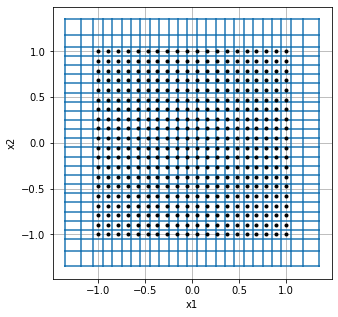

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mesh.plot_grid(ax=ax)
ax.plot(xyz[:, 0], xyz[:, 1], 'k.')

In [145]:
sensorinfo = uxo_utils.CustomSensorInfo.coincident_system(
    tx_width=1., rx_width = 0.1
)

In [146]:
src_list = []
nrx = len(sensorinfo.receivers)

tx = sensorinfo.transmitters[0]
for i in range(xyz.shape[0]):
    tx_corners = tx.shape + xyz[i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receivers = pm.MagneticFluxDensityReceiver(
        np.atleast_2d(xyz[i, :]), 
        components=[rx.component for rx in sensorinfo.receivers]
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=1
    )
    src_list.append(src)

In [147]:
survey = pm.Survey(src_list)

In [148]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [149]:
mtrue = np.zeros_like(locations)

x_target = np.r_[-0.25, 0.25]/2
y_target = np.r_[-0.125, 0.125]/2
m_target = np.r_[1, 1, 1]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtrue[bounding_box, i] = m

mtrue = mtrue.flatten() #discretize.utils.mkvc(mtrue)

In [150]:
def plot_model(model, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    
    for i, label in enumerate(["x", "y", "z"]): 
        plt.colorbar(mesh.plot_image(model[i::3], ax=ax[i])[0], ax=ax[i])
        ax[i].set_title(f"$m_{label}$")
        ax[i].set_aspect(1)
    plt.tight_layout()

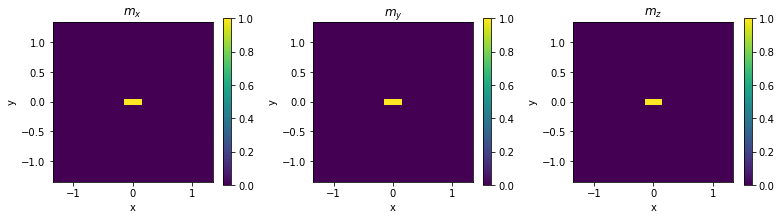

In [151]:
plot_model(mtrue)

In [152]:
dtrue = sim.dpred(mtrue.flatten())
# data_true = simpeg.Data(survey, dtrue)

In [153]:
# plot the data

def plot_data(dplot, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    contour_opts = {
        "cmap": "Spectral_r"
    }
    n_interpolate = 40

    for j, comp in enumerate(src.receiver_list[0].components): 
        dij = dplot[j::3]
        if np.any(dij): 
            contour_opts["vmin"] = -1*np.max(np.abs(dij))
            contour_opts["vmax"] = np.max(np.abs(dij))
            plt.colorbar(
                simpeg.utils.plot2Ddata(
                    xyz[:,:2], dij, ax=ax[j], 
                    contourOpts=contour_opts, nx=n_interpolate, ny=n_interpolate
                )[0], 
                ax=ax[j]
            )
        ax[j].set_title(f"rx: {comp}")
        ax[j].set_aspect(1)
    plt.tight_layout()
    return ax

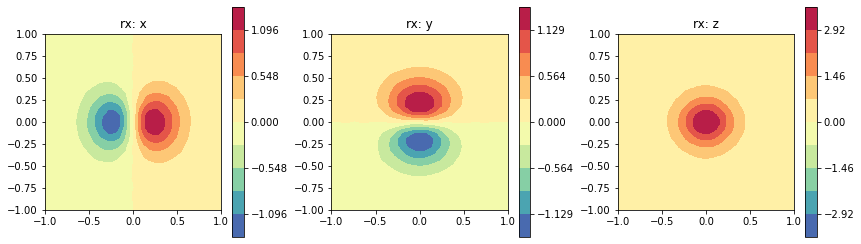

In [154]:
plot_data(dtrue);

# try a simple inversion

In [123]:
locations = np.hstack([mesh.gridCC, 0*np.ones((mesh.nC, 1))])
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [124]:
noise_floor = 0.01 * np.max(np.abs(noise_floor))
inversion_test = pm.Inversion(sim, dtrue, noise_floor, beta=None)

In [125]:
%%time
mrec0 = inversion_test.solve(beta_fact=1)

CPU times: user 39.5 s, sys: 4.15 s, total: 43.6 s
Wall time: 17.1 s


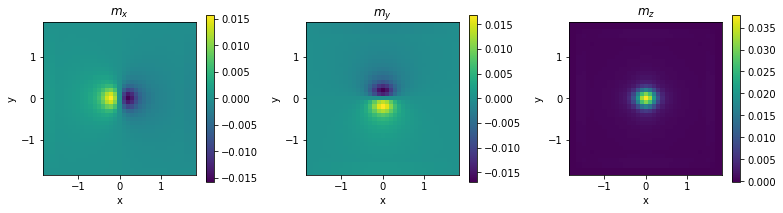

In [126]:
plot_model(mrec0)

# inversion that enforces positivity -- SimPEG

In [127]:
from SimPEG import (
    data_misfit, regularization, optimization, inverse_problem, inversion, directives, Data, maps
)



In [164]:
noise_floor = 0.05 * np.max(np.abs(dtrue))
print(noise_floor)

0.1825173776594523


In [165]:
dmis = data_misfit.L2DataMisfit(
    data=Data(survey, dobs=dtrue, noise_floor=noise_floor), simulation=sim
)

nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [166]:
opt = optimization.ProjectedGNCG(maxIterCG=40, lower=0, maxIter=20) 
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 

In [167]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [168]:
inv = inversion.BaseInversion(invprob, directive_list)

In [169]:
mrec_pos = inv.run(np.zeros(mesh.nC * 3)+1e-20)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.99e+04  4.48e+03  9.38e-38  4.48e+03    1.19e+04      0              
   1  9.97e+03  1.52e+03  5.25e-02  2.04e+03    3.23e+03      0              
   2  4.99e+03  8.18e+02  1.02e-01  1.33e+03    2.25e+03      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.4784e+02
0 : |xc-x_last| = 1.2446e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.2521e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.2521e+03 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          

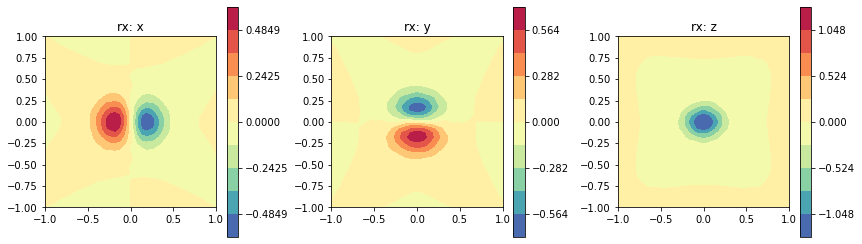

In [170]:
plot_data(invprob.dpred - dtrue);

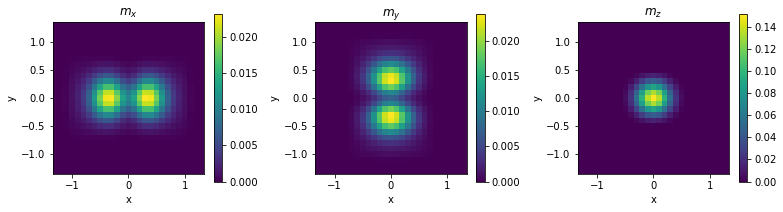

In [171]:
plot_model(mrec_pos)